In [ ]:
!pip install keras-tuner

In [ ]:
# import the necessary packages
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split

from kerastuner import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters

from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import cv2
import os

import warnings
from tqdm import tqdm_notebook as tqdm
import itertools

import tensorflow as tf 
print(tf.__version__)
warnings.filterwarnings("ignore")
SEED = 42   # set random seed

2.7.0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  app.launch_new_instance()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/MyDrive/PGAA08_Deep_Learning/Code Files/Untitled folder")
!dir

dataset  dataset.zip  Optimization.ipynb


In [ ]:
!pip install patool

     |████████████████████████████████| 77 kB 4.3 MB/s 


In [ ]:
# take longer time to run
import patoolib
patoolib.extract_archive("dataset.zip")

patool: Extracting dataset.zip ...
patool: running /usr/bin/7z x -o./Unpack_92ls63xa -- dataset.zip
patool: ... dataset.zip extracted to `dataset' (multiple files in root).


'dataset'

In [ ]:
# print few sample image paths
imagePaths = sorted(list(paths.list_images("dataset")))
imagePaths[:10]

['dataset/normal/1.jpg',
 'dataset/normal/10.jpg',
 'dataset/normal/100.jpg',
 'dataset/normal/101.jpg',
 'dataset/normal/102.jpg',
 'dataset/normal/103.jpg',
 'dataset/normal/104.jpg',
 'dataset/normal/105.jpg',
 'dataset/normal/106.jpg',
 'dataset/normal/107.jpg']

In [ ]:
# initialize the data and labels
print("[INFO] loading images...")
data = []
labels = []

# grab the image paths and randomly shuffle them
imagePaths = sorted(list(paths.list_images("dataset")))
random.seed(42)
random.shuffle(imagePaths)

# progress bar 
with tqdm(total=len(imagePaths)) as pbar:
    
    # loop over the input images
    for idx, imagePath in enumerate(imagePaths):
        # load the image, pre-process it, and store it in the data list
        try:
            image = cv2.imread(imagePath)
            image = cv2.resize(image, (28, 28))
        except :
            continue
        image = img_to_array(image)
        data.append(image)

        # extract the class label from the image path and update the
        # labels list
        label = imagePath.split(os.path.sep)[-2]

        

        if label == "normal":
            label = 0
        elif label == "potholes":
            label = 1
        
        # print("pr: ", label)	

        labels.append(label)
        
        # update the progressbar
        pbar.update(1)

[INFO] loading images...


  0%|          | 0/681 [00:00<?, ?it/s]

In [ ]:
print(len(data))
print(len(labels))

680
680


In [ ]:
data[0].shape

(28, 28, 3)

In [ ]:
x_images = np.array(data, dtype="float") / 255.0
y_labels = np.array(labels)

In [ ]:
len(x_images)

680

In [ ]:
x_images =x_images.reshape(len(x_images),28,28,3)
x_images.shape

(680, 28, 28, 3)

# Model Buildings 

In [ ]:
def build_model(hp):  
  model = Sequential([
    Conv2D(
        filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
        kernel_size=hp.Choice('conv_1_kernel', values = [3,5]),
        activation='relu',
        input_shape=(28,28,3)
    ),

    # MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    # Conv2D(
    #     filters=hp.Int('conv_2_filter', min_value=32, max_value=64, step=16),
    #     kernel_size=hp.Choice('conv_2_kernel', values = [3,5]),
    #     activation='relu'
    # ),

    # Conv2D(
    #     filters=hp.Int('conv_3_filter', min_value=32, max_value=64, step=16),
    #     kernel_size=hp.Choice('conv_3_kernel', values = [3,5]),
    #     activation='relu'
    # ),

    # MaxPooling2D(pool_size=(2, 2), strides=(2, 2)),

    Flatten(),
    
    Dense(
        units=hp.Int('dense_1_units', min_value=32, max_value=128, step=16),
        activation='relu'
    ),

    # Dense(
    #     units=hp.Int('dense_2_units', min_value=32, max_value=128, step=16),
    #     activation='relu'
    # ),

    # Dense(
    #     units=hp.Int('dense_3_units', min_value=32, max_value=128, step=16),
    #     activation='relu'
    # ),

    Dense(2, activation='softmax')
  ])
  
  model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3])),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
  
  return model

In [ ]:
tuner_search=RandomSearch(build_model,
                          objective='accuracy',
                          max_trials=5,directory='output',project_name="Potholes_Detection")

In [ ]:
tuner_search.search(x_images,y_labels,epochs=5,validation_split=0.2)

Trial 5 Complete [00h 00m 05s]
accuracy: 0.9191176295280457

Best accuracy So Far: 0.966911792755127
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit


In [ ]:
model=tuner_search.get_best_models(num_models=1)[0]

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 48)        1344      
                                                                 
 flatten (Flatten)           (None, 32448)             0         
                                                                 
 dense (Dense)               (None, 64)                2076736   
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 2,078,730
Trainable params: 2,078,730
Non-trainable params: 0
_________________________________________________________________


In [ ]:
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

In [ ]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [ ]:
trainX.shape

(510, 28, 28, 3)

In [ ]:
trainY.shape

(510,)

In [ ]:
# construct the image generator for data augmentation
aug = ImageDataGenerator(rotation_range=30, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.2, 
                         zoom_range=0.2, 
                         horizontal_flip=True, 
                         fill_mode="nearest")

In [ ]:

EPOCHS = 25
BS = 32
# train the network
print("[INFO] training network...")
H = model.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/25
15/15 [==============================] - 2s 70ms/step - loss: 0.3604 - accuracy: 0.8347 - val_loss: 0.1208 - val_accuracy: 0.9706
Epoch 2/25
15/15 [==============================] - 1s 47ms/step - loss: 0.3261 - accuracy: 0.8625 - val_loss: 0.2364 - val_accuracy: 0.8941
Epoch 3/25
15/15 [==============================] - 1s 47ms/step - loss: 0.3216 - accuracy: 0.8473 - val_loss: 0.1090 - val_accuracy: 0.9706
Epoch 4/25
15/15 [==============================] - 1s 46ms/step - loss: 0.2910 - accuracy: 0.8787 - val_loss: 0.1004 - val_accuracy: 0.9647
Epoch 5/25
15/15 [==============================] - 1s 47ms/step - loss: 0.2920 - accuracy: 0.8766 - val_loss: 0.1134 - val_accuracy: 0.9765
Epoch 6/25
15/15 [==============================] - 1s 48ms/step - loss: 0.3048 - accuracy: 0.8661 - val_loss: 0.1228 - val_accuracy: 0.9647
Epoch 7/25
15/15 [==============================] - 1s 47ms/step - loss: 0.2814 - accuracy: 0.8766 - val_loss: 0.1588 - val_acc

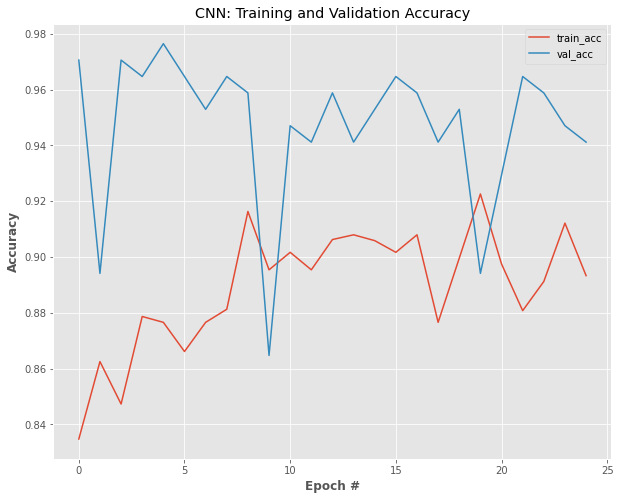

In [ ]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

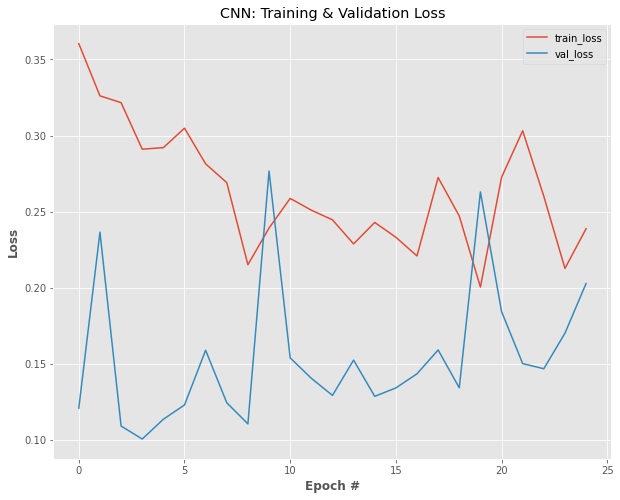

In [ ]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# Model 3

In [ ]:
def model_1(width, height, depth, classes):
    # initialize the model
    model = Sequential()
    inputShape = (height, width, depth) # (h, h, chanel)

    # if we are using "channels first", update the input shape
    if K.image_data_format() == "channels_first":
        inputShape = (depth, height, width)

    # first set of CONV => RELU => POOL layers
    model.add(Conv2D(20, (5, 5), padding="same",input_shape=inputShape))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # second set of CONV => RELU => POOL layers
    model.add(Conv2D(50, (5, 5), padding="same"))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

    # first (and only) set of FC => RELU layers
    model.add(Flatten())
    model.add(Dense(500))
    model.add(Activation("relu"))

    # softmax classifier
    model.add(Dense(classes))
    model.add(Activation("softmax"))

    # return the constructed network architecture
    return model

In [ ]:
# initialize the model
print("[INFO] compiling model...")
model1 = model_1(width=28, height=28, depth=3, classes=2)
EPOCHS = 10
INIT_LR = 1e-3
BS = 32
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model1.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] model complied...")

[INFO] compiling model...
[INFO] model complied...


In [ ]:
trainY[0]

1

In [ ]:
# train the network
print("[INFO] training network...")
H2 = model1.fit(x=aug.flow(trainX, trainY, batch_size=BS),
              validation_data=(testX, testY), 
              steps_per_epoch=len(trainX) // BS,
              epochs=EPOCHS, 
              verbose=1)

[INFO] training network...
Epoch 1/10
15/15 [==============================] - 2s 96ms/step - loss: 0.7136 - accuracy: 0.5460 - val_loss: 0.6507 - val_accuracy: 0.5412
Epoch 2/10
15/15 [==============================] - 1s 85ms/step - loss: 0.5692 - accuracy: 0.7197 - val_loss: 0.4692 - val_accuracy: 0.7412
Epoch 3/10
15/15 [==============================] - 1s 85ms/step - loss: 0.4403 - accuracy: 0.7887 - val_loss: 0.4062 - val_accuracy: 0.8471
Epoch 4/10
15/15 [==============================] - 1s 85ms/step - loss: 0.4543 - accuracy: 0.7929 - val_loss: 0.3786 - val_accuracy: 0.8118
Epoch 5/10
15/15 [==============================] - 1s 85ms/step - loss: 0.3844 - accuracy: 0.8326 - val_loss: 0.2751 - val_accuracy: 0.8824
Epoch 6/10
15/15 [==============================] - 1s 85ms/step - loss: 0.3647 - accuracy: 0.8347 - val_loss: 0.3500 - val_accuracy: 0.8059
Epoch 7/10
15/15 [==============================] - 1s 87ms/step - loss: 0.3670 - accuracy: 0.8389 - val_loss: 0.2547 - val_acc

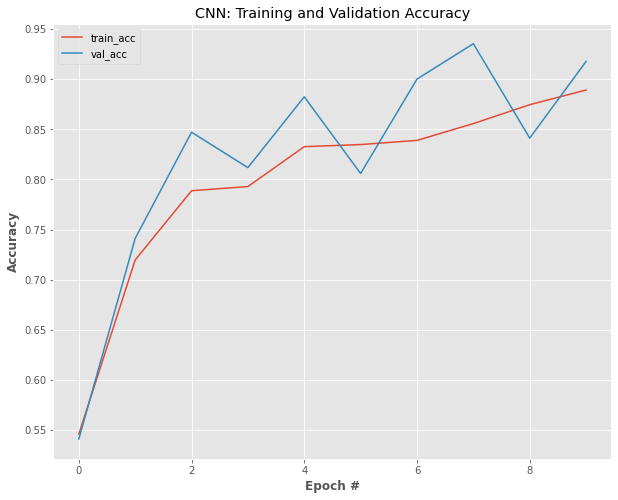

In [ ]:
# plot the training and validation accuracy
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["accuracy"], label="train_acc")
plt.plot(N, H2.history["val_accuracy"], label="val_acc")
plt.title("CNN: Training and Validation Accuracy")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Accuracy", weight="bold")
plt.legend()
plt.show()

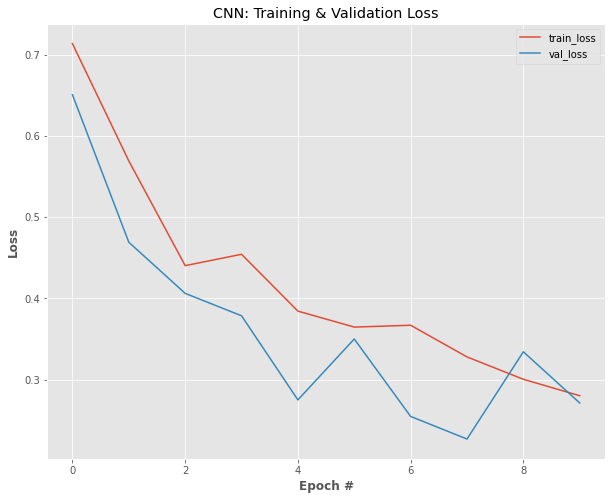

In [ ]:
# plot the training and validation loss
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize = [10,8])
plt.plot(N, H2.history["loss"], label="train_loss")
plt.plot(N, H2.history["val_loss"], label="val_loss")
plt.title("CNN: Training & Validation Loss")
plt.xlabel("Epoch #", weight="bold")
plt.ylabel("Loss", weight="bold")
plt.legend()
plt.show()

# inference [homework]

In [ ]:
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import numpy as np
import argparse
import imutils
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def display_img(img):
    fig = plt.figure(figsize=(12,10))
    plt.grid(b=None)
    ax = fig.add_subplot(111)
    ax.imshow(img)

In [ ]:
# import the necessary packages
from tensorflow.keras.models import load_model
import pickle
import cv2

# # load the model 
print("[INFO] loading network and...")
# model = load_model(MODEL)

# grab the image paths and randomly shuffle themt
testImagePaths = sorted(list(paths.list_images('test_images')))   # data folder with 2 categorical folders

all_class = ["potholes", "Normal"]


# progress bar 
with tqdm(total=len(testImagePaths)) as pbar:
    
    for imagePath in testImagePaths:
        
        # load the image
        image = cv2.imread(imagePath)
        orig = image.copy()

        # pre-process the image for classification
        image = cv2.resize(image, (28, 28))
        image = image.astype("float") / 255.0
        image = img_to_array(image)
        image = np.expand_dims(image, axis=0)

        # classify the input image
        prd_conf = model1.predict(image)[0]

        print(len(prd_conf))
        print(np.argmax(prd_conf))
        # # build the label
        # label = all_class[np.argmax(prd_conf)]
        # proba = prd_conf[np.argmax(prd_conf)]

        # label = "{}: {:.2f}%".format(label, proba * 100)

        # # draw the label on the image
        # output = imutils.resize(orig, width=400)
        # cv2.putText(output, label, (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,
        #     0.7, (255, 0, 0), 2)
        
        # # convert img to rgb format and display in notebook
        # img = cv2.cvtColor(output, cv2.COLOR_BGR2RGB)
        # display_img(img)
        
        pbar.update(1)


[INFO] loading network and...


  0%|          | 0/3 [00:00<?, ?it/s]

2
0
2
1
2
0


In [ ]:
!pip install gradio